# Customer Churn Prediction - Supervised Learning Demo
Binary Classification using Random Forest

**Dataset:** [Telco Customer Churn from Kaggle](https://www.kaggle.com/datasets/blastchar/telco-customer-churn)

**Package Requirements:**
- pandas 2.3.2
- numpy 2.2.6
- scikit-learn 1.7.2
- matplotlib 3.10.7
- seaborn 0.13.2


In [1]:
"""
Customer Churn Prediction - Supervised Learning Demo
Binary Classification using Random Forest

Dataset: Telco Customer Churn from Kaggle
https://www.kaggle.com/datasets/blastchar/telco-customer-churn

Package Requirements:

pandas 2.3.2
numpy 2.2.6
scikit-learn 1.7.2
matplotlib 3.10.7
seaborn 0.13.2
"""

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, 
    recall_score, f1_score, roc_auc_score, classification_report
)
from sklearn.tree import plot_tree, export_text
import matplotlib.pyplot as plt
import seaborn as sns


Load and prepare data

In [2]:
def load_data():

SyntaxError: incomplete input (1259908393.py, line 1)

Load the Telco Customer Churn dataset

In [3]:
    #Download from: https://www.kaggle.com/datasets/blastchar/telco-customer-churn
    

For demo purposes, using publicly available dataset

In [4]:
    #url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"

WA_Fn-UseC_-Telco-Customer-Churn

In [5]:
    #df = pd.read_csv(url)
    df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
    
    
    print("\n" + "="*60)
    print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
    print(f"\nChurn distribution:\n{df['Churn'].value_counts()}")
    print("="*60)
    return df

def preprocess_data(df):

SyntaxError: incomplete input (77318490.py, line 11)

Clean and prepare data for modeling

In [6]:
    #Make a copy to avoid warnings
    df = df.copy()
    

NameError: name 'df' is not defined

Convert TotalCharges to numeric and fill missing values

In [7]:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())
    

NameError: name 'df' is not defined

Drop customerID

In [8]:
    df = df.drop('customerID', axis=1)
    

NameError: name 'df' is not defined

Convert target variable

In [9]:
    df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
    

NameError: name 'df' is not defined

Encode categorical variables

In [10]:
    le = LabelEncoder()
    categorical_cols = df.select_dtypes(include=['object']).columns
    
    for col in categorical_cols:
        df[col] = le.fit_transform(df[col])
    
    print("\n" + "="*60)
    print(f"Data preprocessed. Shape: {df.shape}")
    print("="*60)
    return df

def train_model(X_train, y_train):
    """Train Random Forest Classifier"""
    print("\n" + "="*60)
    print("Training Random Forest Classifier...")
    

IndentationError: expected an indented block after function definition on line 12 (3971969925.py, line 13)

Initialize model with balanced class weights

In [11]:
    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=4,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    

Train model

In [12]:
    model.fit(X_train, y_train)
    print("Model training completed!")
    print("="*60)
    return model

def evaluate_model(model, X_test, y_test):
    """model evaluation"""

IndentationError: expected an indented block after function definition on line 6 (2897552849.py, line 7)

Predictions

In [13]:
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    

NameError: name 'X_test' is not defined

Calculate metrics

In [14]:
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    

NameError: name 'y_test' is not defined

Confusion matrix

In [15]:
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    print("\n" + "="*60)
    print("MODEL EVALUATION RESULTS")
    print("="*60)
    print(f"\nAccuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Precision: {precision:.4f} ({precision*100:.2f}%)")
    print(f"Recall:    {recall:.4f} ({recall*100:.2f}%)")
    print(f"F1-Score:  {f1:.4f} ({f1*100:.2f}%)")
    print(f"ROC-AUC:   {roc_auc:.4f} ({roc_auc*100:.2f}%)")
    
    print(f"\n{'CONFUSION MATRIX':^40}")
    print(f"{'':20} {'Predicted':^20}")
    print(f"{'':20} {'No Churn':^10} {'Churn':^10}")
    print(f"{'Actual No Churn':20} {tn:^10} {fp:^10}")
    print(f"{'Actual Churn':20} {fn:^10} {tp:^10}")
    
    print(f"\nTrue Negatives (TN):  {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"True Positives (TP):  {tp}")
    
    print("\n" + classification_report(y_test, y_pred, 
                                       target_names=['No Churn', 'Churn']))
    

NameError: name 'y_test' is not defined

Visualize confusion matrix

In [16]:
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Churn', 'Churn'],
                yticklabels=['No Churn', 'Churn'])
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    print("\nConfusion matrix saved as 'confusion_matrix.png'")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'confusion_matrix': {'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp}
    }

def feature_importance(model, feature_names):
    """Display feature importance"""
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:10]
    
    print("\n" + "="*60)
    print("TOP 10 MOST IMPORTANT FEATURES")
    print("="*60)
    for i, idx in enumerate(indices, 1):
        print(f"{i:2d}. {feature_names[idx]:30s} {importances[idx]:.4f}")
    

IndentationError: expected an indented block after function definition on line 21 (1879647276.py, line 22)

Visualize feature importance

In [17]:
    plt.figure(figsize=(10, 6))
    plt.bar(range(10), importances[indices])
    plt.xticks(range(10), [feature_names[i] for i in indices], rotation=45, ha='right')
    plt.title('Top 10 Feature Importances')
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    print("\nFeature importance plot saved as 'feature_importance.png'")

def test_cases(model, feature_names):
    """Test with specific examples"""
    print("\n" + "="*60)
    print("TEST PREDICTIONS")
    print("="*60)
    

IndentationError: expected an indented block after function definition on line 11 (2038315631.py, line 12)

Test Case 1

In [18]:
    testcase1 = {
        'gender': 1, 'SeniorCitizen': 0, 'Partner': 0, 'Dependents': 0,
        'tenure': 3, 'PhoneService': 1, 'MultipleLines': 0, 
        'InternetService': 1, 'OnlineSecurity': 0, 'OnlineBackup': 0,
        'DeviceProtection': 0, 'TechSupport': 0, 'StreamingTV': 0,
        'StreamingMovies': 0, 'Contract': 0, 'PaperlessBilling': 1,
        'PaymentMethod': 2, 'MonthlyCharges': 95.0, 'TotalCharges': 285.0
    }
    

Test Case 2

In [19]:
    testcase2 = {
        'gender': 0, 'SeniorCitizen': 1, 'Partner': 1, 'Dependents': 1,
        'tenure': 60, 'PhoneService': 1, 'MultipleLines': 1,
        'InternetService': 0, 'OnlineSecurity': 2, 'OnlineBackup': 1,
        'DeviceProtection': 1, 'TechSupport': 1, 'StreamingTV': 1,
        'StreamingMovies': 1, 'Contract': 2, 'PaperlessBilling': 0,
        'PaymentMethod': 0, 'MonthlyCharges': 55.0, 'TotalCharges': 3300.0
    }
    

Test Case 3

In [20]:
    testcase3 = {
        'gender': 1, 'SeniorCitizen': 0, 'Partner': 1, 'Dependents': 0,
        'tenure': 18, 'PhoneService': 1, 'MultipleLines': 1,
        'InternetService': 1, 'OnlineSecurity': 0, 'OnlineBackup': 1,
        'DeviceProtection': 1, 'TechSupport': 1, 'StreamingTV': 0,
        'StreamingMovies': 1, 'Contract': 1, 'PaperlessBilling': 1,
        'PaymentMethod': 1, 'MonthlyCharges': 70.0, 'TotalCharges': 1260.0
    }
    

Test Case 4

In [21]:
    testcase4 = {
        'gender': 1, 'SeniorCitizen': 0, 'Partner': 1, 'Dependents': 8,
        'tenure': 18, 'PhoneService': 0, 'MultipleLines': 0,
        'InternetService': 1, 'OnlineSecurity': 0, 'OnlineBackup': 0,
        'DeviceProtection': 0, 'TechSupport': 0, 'StreamingTV': 1,
        'StreamingMovies': 1, 'Contract': 1, 'PaperlessBilling': 1,
        'PaymentMethod': 1, 'MonthlyCharges': 200.0, 'TotalCharges': 1260.0
    }
    
    testcases = [
        ("Test Case 1: New customer, expensive, month-to-month, no support", testcase1),
        ("Test Case 2: Long tenure, 2-year contract, full services", testcase2),
        ("Test Case 3: Moderate tenure, 1-year contract, mixed services", testcase3),
        ("Test Case 4: Moderate tenure, 8 dependents, 1-year contract, mixed services", testcase4)
    ]
    
    for desc, testcase in testcases:
        X_testcase = pd.DataFrame([testcase])[feature_names]
        pred = model.predict(X_testcase)[0]
        proba = model.predict_proba(X_testcase)[0]
        
        print(f"\n{desc}")
        print(f"  Prediction: {'CHURN' if pred == 1 else 'NO CHURN'}")
        print(f"  Probability: {proba[1]*100:.1f}% chance of churn")
        
def visualize_single_tree(model, feature_names, tree_index=0):

SyntaxError: incomplete input (1372794964.py, line 26)

Visualize a single decision tree from the Random Forest model

Get a single tree from the forest

In [22]:
    single_tree = model.estimators_[tree_index]
    

AttributeError: 'RandomForestClassifier' object has no attribute 'estimators_'

Create visualization

In [23]:
    plt.figure(figsize=(20, 10))
    plot_tree(single_tree, 
              feature_names=feature_names,
              class_names=['No Churn', 'Churn'],
              filled=True,
              rounded=True,
              fontsize=10)
    plt.title(f'Decision Tree #{tree_index} from Random Forest')
    plt.tight_layout()
    plt.savefig(f'decision_tree_{tree_index}.png', dpi=300, bbox_inches='tight')
    print(f"\nDecision tree #{tree_index} saved as 'decision_tree_{tree_index}.png'")
    

NameError: name 'single_tree' is not defined

<Figure size 2000x1000 with 0 Axes>

Also export text representation

In [24]:
    tree_rules = export_text(single_tree, feature_names=feature_names)
    with open(f'tree_rules_{tree_index}.txt', 'w') as f:
        f.write(tree_rules)
    print(f"Tree rules saved as 'tree_rules_{tree_index}.txt'")


def main():

    """Starting the analysis"""
    print("="*60)
    print("Course: INFO-629-686 - FA 25-26")
    print("Assignment 3: SUPERVISED LEARNING DEMO - CUSTOMER CHURN PREDICTION")
    print("Student: Anthony Parone")
    print("Date: November 2025")
    print("="*60)
    

IndentationError: expected an indented block after function definition on line 7 (485194179.py, line 9)

Load the data into a dataframe

In [25]:
    df = load_data()
    

NameError: name 'load_data' is not defined

2 Preprocess - this cleans up the data for the model training

In [26]:
    df = preprocess_data(df)
    

NameError: name 'preprocess_data' is not defined

3 Split features and target

In [27]:
    #remove the column churn and leave all the features for X
    X = df.drop('Churn', axis=1)

NameError: name 'df' is not defined

only the churn values get assigned to Y

In [28]:
    y = df['Churn']
    print("\n" + "="*60)
    print(f"Class distribution:")
    print(f"  No Churn: {(y==0).sum()} ({(y==0).sum()/len(y)*100:.1f}%)")
    print(f"  Churn:    {(y==1).sum()} ({(y==1).sum()/len(y)*100:.1f}%)")
    print("="*60)
    

NameError: name 'df' is not defined

Train-test split - The Split Creates 4 Sets:

In [29]:
    #`X_train`** - Features for training (70% of data)

**`X_test`** - Features for testing (30% of data)

In [30]:
    # **`y_train`** - Target labels for training (70% of data)

**`y_test`** - Target labels for testing (30% of data)

In [31]:
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    '''
train_test_split: A function from sklearn.model_selection that splits your dataset into training and testing subsets.
X: Your feature matrix (all input variables except the target).
y: Your target variable (in this case, Churn).
test_size=0.3: 30% of the data will be used for testing, and 70% for training.
random_state=42: Sets a fixed seed for reproducibility. Using the same seed ensures you get the same split every time you run the code.
stratify=y: Ensures that the proportion of classes (Churn vs. No Churn) is preserved in both training and testing sets. This is important for imbalanced datasets.
'''
    print(f"\nTrain set: {X_train.shape[0]} samples")
    print(f"Test set:  {X_test.shape[0]} samples")
    

NameError: name 'X' is not defined

Train model

In [32]:
    model = train_model(X_train, y_train)

NameError: name 'train_model' is not defined

vizualize one tree

In [33]:
    visualize_single_tree(model, X.columns.tolist(), tree_index=0)
    

NameError: name 'visualize_single_tree' is not defined

Evaluate

In [34]:
    metrics = evaluate_model(model, X_test, y_test)
    

NameError: name 'evaluate_model' is not defined

Feature importance

In [35]:
    feature_importance(model, X.columns.tolist())
    

NameError: name 'feature_importance' is not defined

Test examples

In [36]:
    test_cases(model, X.columns.tolist())
    

NameError: name 'test_cases' is not defined

print("\n" + "="*60)

In [37]:
    #print("DEMO COMPLETED SUCCESSFULLY")

print("="*60)

if __name__ == "__main__":

In [38]:
main()



NameError: name 'main' is not defined

Course: INFO-629-686 - FA 25-26
Assignment 3: SUPERVISED LEARNING DEMO - CUSTOMER CHURN PREDICTION
Student: Anthony Parone
Date: November 2025

Dataset loaded: 7043 rows, 21 columns

Churn distribution:
Churn
No     5174
Yes    1869
Name: count, dtype: int64

Data preprocessed. Shape: (7043, 20)

Class distribution:
  No Churn: 5174 (73.5%)
  Churn:    1869 (26.5%)

Train set: 4930 samples
Test set:  2113 samples

Training Random Forest Classifier...
Model training completed!

Decision tree #0 saved as 'decision_tree_0.png'
Tree rules saved as 'tree_rules_0.txt'

MODEL EVALUATION RESULTS

Accuracy:  0.7672 (76.72%)
Precision: 0.5456 (54.56%)
Recall:    0.7362 (73.62%)
F1-Score:  0.6267 (62.67%)
ROC-AUC:   0.8402 (84.02%)

            CONFUSION MATRIX            
                          Predicted      
                      No Churn    Churn   
Actual No Churn         1208       344    
Actual Churn            148        413    

True Negatives (TN):  1208
False Positives (FP): 344
Fa

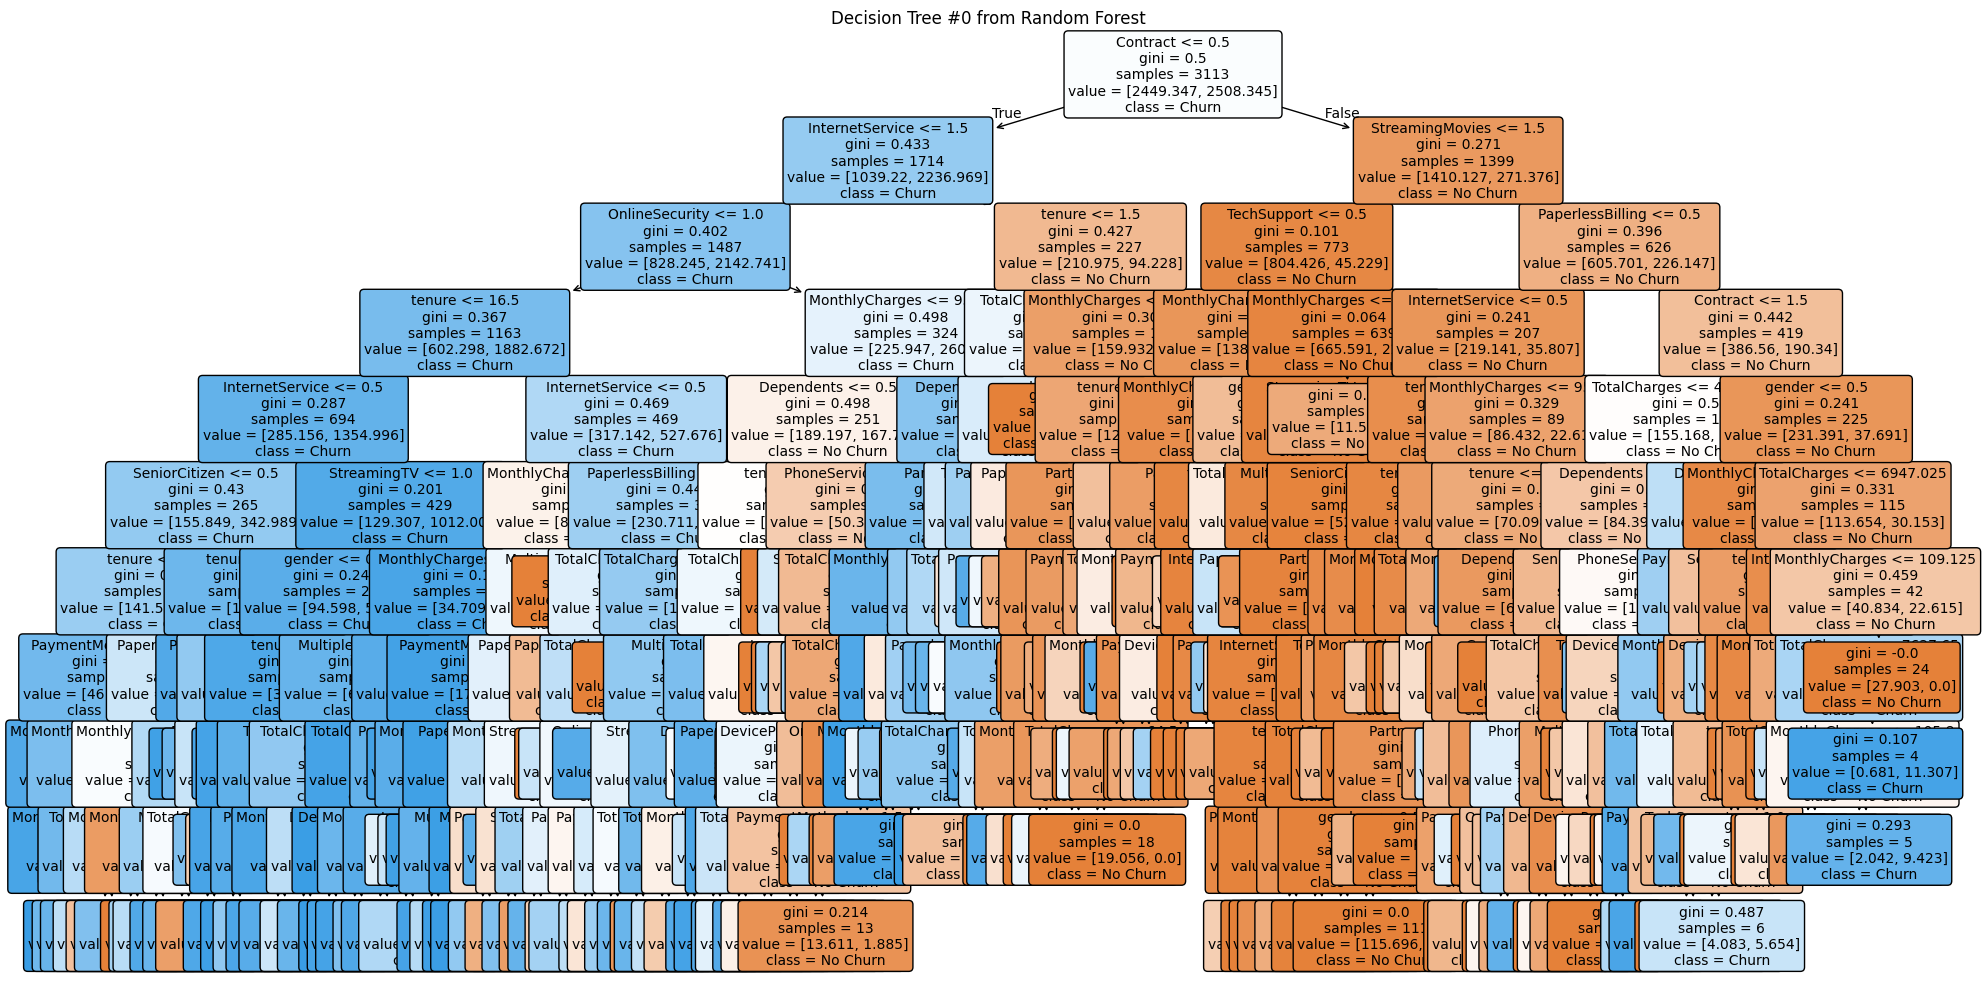

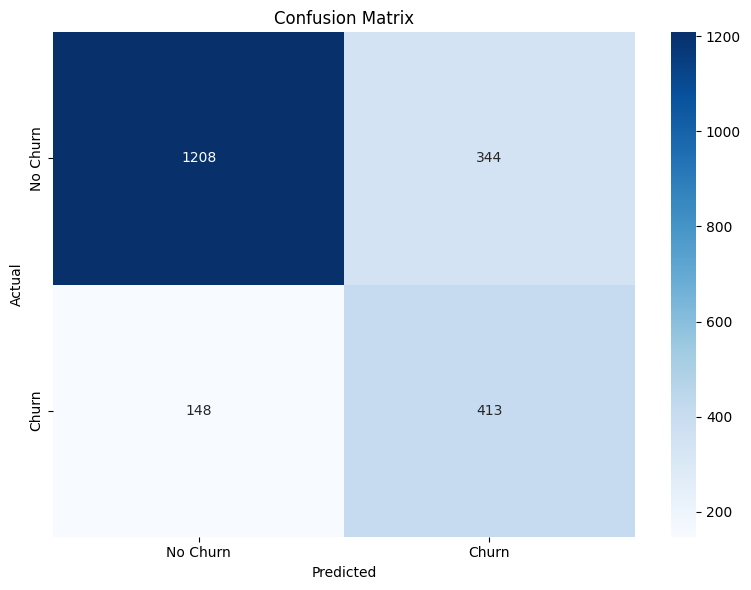

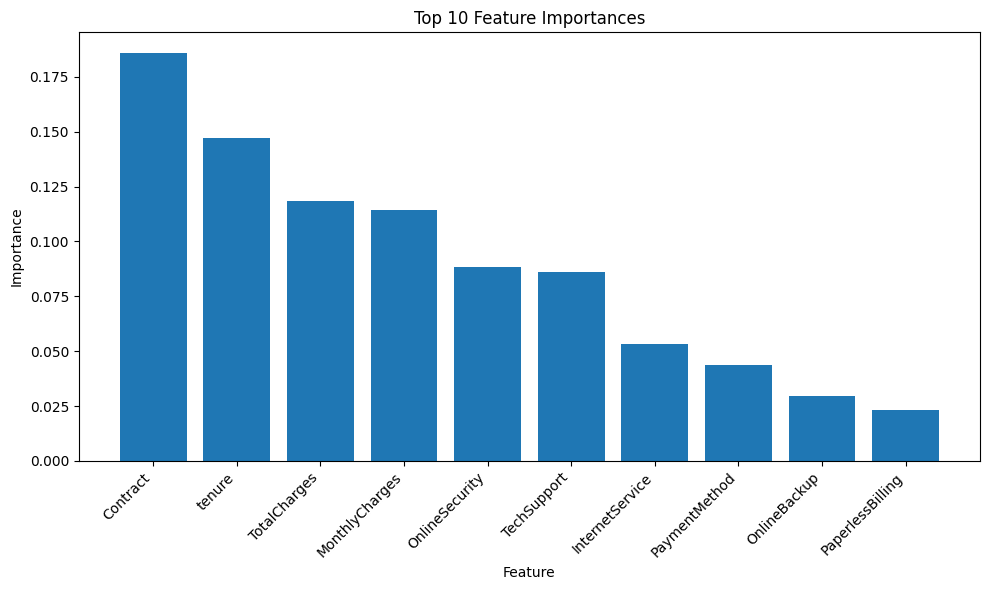

In [39]:
"""
Customer Churn Prediction - Supervised Learning Demo
Binary Classification using Random Forest

Dataset: Telco Customer Churn from Kaggle
https://www.kaggle.com/datasets/blastchar/telco-customer-churn

Package Requirements:

pandas 2.3.2
numpy 2.2.6
scikit-learn 1.7.2
matplotlib 3.10.7
seaborn 0.13.2
"""

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, 
    recall_score, f1_score, roc_auc_score, classification_report
)
from sklearn.tree import plot_tree, export_text
import matplotlib.pyplot as plt
import seaborn as sns

# Load and prepare data
def load_data():
    #Load the Telco Customer Churn dataset
    #Download from: https://www.kaggle.com/datasets/blastchar/telco-customer-churn
    
    # For demo purposes, using publicly available dataset
    #url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"
    #WA_Fn-UseC_-Telco-Customer-Churn
    #df = pd.read_csv(url)
    df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
    
    
    print("\n" + "="*60)
    print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
    print(f"\nChurn distribution:\n{df['Churn'].value_counts()}")
    print("="*60)
    return df

def preprocess_data(df):
    #Clean and prepare data for modeling
    #Make a copy to avoid warnings
    df = df.copy()
    
    # Convert TotalCharges to numeric and fill missing values
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())
    
    # Drop customerID
    df = df.drop('customerID', axis=1)
    
    # Convert target variable
    df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
    
    # Encode categorical variables
    le = LabelEncoder()
    categorical_cols = df.select_dtypes(include=['object']).columns
    
    for col in categorical_cols:
        df[col] = le.fit_transform(df[col])
    
    print("\n" + "="*60)
    print(f"Data preprocessed. Shape: {df.shape}")
    print("="*60)
    return df

def train_model(X_train, y_train):
    """Train Random Forest Classifier"""
    print("\n" + "="*60)
    print("Training Random Forest Classifier...")
    
    # Initialize model with balanced class weights
    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=4,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    
    # Train model
    model.fit(X_train, y_train)
    print("Model training completed!")
    print("="*60)
    return model

def evaluate_model(model, X_test, y_test):
    """model evaluation"""
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    print("\n" + "="*60)
    print("MODEL EVALUATION RESULTS")
    print("="*60)
    print(f"\nAccuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Precision: {precision:.4f} ({precision*100:.2f}%)")
    print(f"Recall:    {recall:.4f} ({recall*100:.2f}%)")
    print(f"F1-Score:  {f1:.4f} ({f1*100:.2f}%)")
    print(f"ROC-AUC:   {roc_auc:.4f} ({roc_auc*100:.2f}%)")
    
    print(f"\n{'CONFUSION MATRIX':^40}")
    print(f"{'':20} {'Predicted':^20}")
    print(f"{'':20} {'No Churn':^10} {'Churn':^10}")
    print(f"{'Actual No Churn':20} {tn:^10} {fp:^10}")
    print(f"{'Actual Churn':20} {fn:^10} {tp:^10}")
    
    print(f"\nTrue Negatives (TN):  {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"True Positives (TP):  {tp}")
    
    print("\n" + classification_report(y_test, y_pred, 
                                       target_names=['No Churn', 'Churn']))
    
    # Visualize confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Churn', 'Churn'],
                yticklabels=['No Churn', 'Churn'])
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    print("\nConfusion matrix saved as 'confusion_matrix.png'")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'confusion_matrix': {'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp}
    }

def feature_importance(model, feature_names):
    """Display feature importance"""
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:10]
    
    print("\n" + "="*60)
    print("TOP 10 MOST IMPORTANT FEATURES")
    print("="*60)
    for i, idx in enumerate(indices, 1):
        print(f"{i:2d}. {feature_names[idx]:30s} {importances[idx]:.4f}")
    
    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(range(10), importances[indices])
    plt.xticks(range(10), [feature_names[i] for i in indices], rotation=45, ha='right')
    plt.title('Top 10 Feature Importances')
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    print("\nFeature importance plot saved as 'feature_importance.png'")

def test_cases(model, feature_names):
    """Test with specific examples"""
    print("\n" + "="*60)
    print("TEST PREDICTIONS")
    print("="*60)
    
    # Test Case 1
    testcase1 = {
        'gender': 1, 'SeniorCitizen': 0, 'Partner': 0, 'Dependents': 0,
        'tenure': 3, 'PhoneService': 1, 'MultipleLines': 0, 
        'InternetService': 1, 'OnlineSecurity': 0, 'OnlineBackup': 0,
        'DeviceProtection': 0, 'TechSupport': 0, 'StreamingTV': 0,
        'StreamingMovies': 0, 'Contract': 0, 'PaperlessBilling': 1,
        'PaymentMethod': 2, 'MonthlyCharges': 95.0, 'TotalCharges': 285.0
    }
    
    # Test Case 2
    testcase2 = {
        'gender': 0, 'SeniorCitizen': 1, 'Partner': 1, 'Dependents': 1,
        'tenure': 60, 'PhoneService': 1, 'MultipleLines': 1,
        'InternetService': 0, 'OnlineSecurity': 2, 'OnlineBackup': 1,
        'DeviceProtection': 1, 'TechSupport': 1, 'StreamingTV': 1,
        'StreamingMovies': 1, 'Contract': 2, 'PaperlessBilling': 0,
        'PaymentMethod': 0, 'MonthlyCharges': 55.0, 'TotalCharges': 3300.0
    }
    
    # Test Case 3
    testcase3 = {
        'gender': 1, 'SeniorCitizen': 0, 'Partner': 1, 'Dependents': 0,
        'tenure': 18, 'PhoneService': 1, 'MultipleLines': 1,
        'InternetService': 1, 'OnlineSecurity': 0, 'OnlineBackup': 1,
        'DeviceProtection': 1, 'TechSupport': 1, 'StreamingTV': 0,
        'StreamingMovies': 1, 'Contract': 1, 'PaperlessBilling': 1,
        'PaymentMethod': 1, 'MonthlyCharges': 70.0, 'TotalCharges': 1260.0
    }
    
    # Test Case 4
    testcase4 = {
        'gender': 1, 'SeniorCitizen': 0, 'Partner': 1, 'Dependents': 8,
        'tenure': 18, 'PhoneService': 0, 'MultipleLines': 0,
        'InternetService': 1, 'OnlineSecurity': 0, 'OnlineBackup': 0,
        'DeviceProtection': 0, 'TechSupport': 0, 'StreamingTV': 1,
        'StreamingMovies': 1, 'Contract': 1, 'PaperlessBilling': 1,
        'PaymentMethod': 1, 'MonthlyCharges': 200.0, 'TotalCharges': 1260.0
    }
    
    testcases = [
        ("Test Case 1: New customer, expensive, month-to-month, no support", testcase1),
        ("Test Case 2: Long tenure, 2-year contract, full services", testcase2),
        ("Test Case 3: Moderate tenure, 1-year contract, mixed services", testcase3),
        ("Test Case 4: Moderate tenure, 8 dependents, 1-year contract, mixed services", testcase4)
    ]
    
    for desc, testcase in testcases:
        X_testcase = pd.DataFrame([testcase])[feature_names]
        pred = model.predict(X_testcase)[0]
        proba = model.predict_proba(X_testcase)[0]
        
        print(f"\n{desc}")
        print(f"  Prediction: {'CHURN' if pred == 1 else 'NO CHURN'}")
        print(f"  Probability: {proba[1]*100:.1f}% chance of churn")
        
def visualize_single_tree(model, feature_names, tree_index=0):
    #Visualize a single decision tree from the Random Forest model
    
    # Get a single tree from the forest
    single_tree = model.estimators_[tree_index]
    
    # Create visualization
    plt.figure(figsize=(20, 10))
    plot_tree(single_tree, 
              feature_names=feature_names,
              class_names=['No Churn', 'Churn'],
              filled=True,
              rounded=True,
              fontsize=10)
    plt.title(f'Decision Tree #{tree_index} from Random Forest')
    plt.tight_layout()
    plt.savefig(f'decision_tree_{tree_index}.png', dpi=300, bbox_inches='tight')
    print(f"\nDecision tree #{tree_index} saved as 'decision_tree_{tree_index}.png'")
    
    # Also export text representation
    tree_rules = export_text(single_tree, feature_names=feature_names)
    with open(f'tree_rules_{tree_index}.txt', 'w') as f:
        f.write(tree_rules)
    print(f"Tree rules saved as 'tree_rules_{tree_index}.txt'")


def main():

    """Starting the analysis"""
    print("="*60)
    print("Course: INFO-629-686 - FA 25-26")
    print("Assignment 3: SUPERVISED LEARNING DEMO - CUSTOMER CHURN PREDICTION")
    print("Student: Anthony Parone")
    print("Date: November 2025")
    print("="*60)
    
    # Load the data into a dataframe
    df = load_data()
    
    #2 Preprocess - this cleans up the data for the model training
    df = preprocess_data(df)
    
    #3 Split features and target
    #remove the column churn and leave all the features for X
    X = df.drop('Churn', axis=1)
    #only the churn values get assigned to Y
    y = df['Churn']
    print("\n" + "="*60)
    print(f"Class distribution:")
    print(f"  No Churn: {(y==0).sum()} ({(y==0).sum()/len(y)*100:.1f}%)")
    print(f"  Churn:    {(y==1).sum()} ({(y==1).sum()/len(y)*100:.1f}%)")
    print("="*60)
    
    # Train-test split - The Split Creates 4 Sets:
    #`X_train`** - Features for training (70% of data)
    #**`X_test`** - Features for testing (30% of data)
    # **`y_train`** - Target labels for training (70% of data)
    #**`y_test`** - Target labels for testing (30% of data)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    '''
train_test_split: A function from sklearn.model_selection that splits your dataset into training and testing subsets.
X: Your feature matrix (all input variables except the target).
y: Your target variable (in this case, Churn).
test_size=0.3: 30% of the data will be used for testing, and 70% for training.
random_state=42: Sets a fixed seed for reproducibility. Using the same seed ensures you get the same split every time you run the code.
stratify=y: Ensures that the proportion of classes (Churn vs. No Churn) is preserved in both training and testing sets. This is important for imbalanced datasets.
'''
    print(f"\nTrain set: {X_train.shape[0]} samples")
    print(f"Test set:  {X_test.shape[0]} samples")
    
    # Train model
    model = train_model(X_train, y_train)
    #vizualize one tree
    visualize_single_tree(model, X.columns.tolist(), tree_index=0)
    
    # Evaluate
    metrics = evaluate_model(model, X_test, y_test)
    
    # Feature importance
    feature_importance(model, X.columns.tolist())
    
    # Test examples
    test_cases(model, X.columns.tolist())
    
    #print("\n" + "="*60)
    #print("DEMO COMPLETED SUCCESSFULLY")
    #print("="*60)

#if __name__ == "__main__":
main()


